In [1]:
# for computing
import numpy as np
import xarray as xr # for reading/writing netcdf
import dask
import pandas as pd # only used for date times

# convenience things
from time import time as timer
import glob # for system ls
from natsort import natsorted # for alphabetical sorting

# for plotting
import matplotlib.pyplot as plt

In [2]:
year=1980
varnames=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m','Rhum','Wind-2m']
months=np.arange(12)+1

# your notebook directory location
repo_dir='/work/hpc/users/kerrie/UN_FAO/repos/py_AEZ_data_prep/'
nb_link='https://github.com/kerriegeil/pyAEZ_data_prep/blob/main/global/03_create_pyaez_daily.ipynb'

# your data directory locations
# ddev_dir='/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/'
ddev_dir='/work/hpc/datasets/un_fao/gaez/global_1980/dailydev/netcdf/'
# mon_dir='/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/'
mon_dir='/work/hpc/datasets/un_fao/pyaez/global_1980/monthly/netcdf/'
# day_dir='/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/'
day_dir='/work/hpc/datasets/un_fao/pyaez/global_1980/daily/netcdf/'

# metadata for output data files
timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
lat_encoding={'_FillValue':None}
lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}
lon_encoding={'_FillValue':None}

source_data=[ddev_dir+'*_DailyDev_'+str(year)+'_5m.nc',mon_dir+'*_monthly_'+str(year)+'_5m.nc']
source_code=nb_link

In [3]:
# daily deviations
ddfiles=natsorted(glob.glob(ddev_dir+'*_DailyDev_'+str(year)+'_*.nc'))
# monthly data
mfiles=natsorted(glob.glob(mon_dir+'*_monthly_'+str(year)+'_*.nc'))

ddfiles,mfiles

(['/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/Precip_DailyDev_1980_5m.nc',
  '/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/Srad_DailyDev_1980_5m.nc',
  '/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/Tmax-2m_DailyDev_1980_5m.nc',
  '/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/Tmin-2m_DailyDev_1980_5m.nc',
  '/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/Vapr_DailyDev_1980_5m.nc',
  '/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/Wind-10m_DailyDev_1980_5m.nc'],
 ['/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Precip_monthly_1980_5m.nc',
  '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Srad_monthly_1980_5m.nc',
  '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Tmax-2m_monthly_1980_5m.nc',
  '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Tmin-2m_mont

In [4]:
# dask single machine (as opposed to using distributed)
# this function is lazy, i.e. only loads metadata into memory and does no computation

def lazy_daily_ds(iv):

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        # get daily dev data as dask array
        var_prime=xr.open_dataset(ddfiles[iv], chunks=-1)[varnames[iv]]

        # get monthly data as dask array
        var_mean=xr.open_dataset(mfiles[iv],chunks=-1)[varnames[iv]]

        # save variable metadata
        varattrs=var_mean.attrs
        del varattrs['description']

        # rework metadata for the groupby below
        var_mean=var_mean.rename({'time':'month'})
        var_mean['month']=months

        # daily data lazy comp
        var_daily=var_prime.groupby('time.month')+var_mean

        # clean up variable metadata
        var_daily=var_daily.drop('month')
        var_daily.attrs=varattrs

        # convert array to dataset and set global attributes
        ds=var_daily.to_dataset()
        ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})

        return ds    

In [5]:
# This function executes the computation and writes the datafile

def compute_and_write_nc(ds,iv,var_encoding):
    start=timer()

    # write to file
    ds.to_netcdf(day_dir+varnames[iv]+'_daily_'+str(year)+'_5m.nc',
                encoding={'lat':lat_encoding,'lon':lon_encoding,'time':time_encoding,varnames[iv]:var_encoding})

    tasktime = timer()-start
    print('complete in',tasktime,'s')

### Precip

In [ ]:
iv=0
ds=lazy_daily_ds(iv)
ds[varnames[iv]].attrs['units']='mm/day'
# ds

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,iv,var_encoding)

### Srad

In [ ]:
iv=1
ds=lazy_daily_ds(iv)

# save and update metadata
attrs=ds[varnames[iv]].attrs
attrs['units']='W/m2'

# Convert J/m2/day to W/m2
s_per_day=86400
ds[varnames[iv]]=ds[varnames[iv]]/s_per_day
ds[varnames[iv]].attrs=attrs
# ds

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,iv,var_encoding)

### Tmax-2m

In [ ]:
iv=2
ds=lazy_daily_ds(iv)
# ds

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,iv,var_encoding)

### Tmin-2m

In [ ]:
iv=3
ds=lazy_daily_ds(iv)
# ds

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,iv,var_encoding)

### Vapr --> Rhum

In [7]:
# lazy get vapor pressure
iv=4
ds=lazy_daily_ds(iv)[varnames[iv]]
# vapr=vapr*0.1

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,iv,var_encoding)

complete in 205.5187418460846 s


In [ ]:
# lazy get vapr
vapr=xr.open_dataset(day_dir+'Vapr_daily_1980_5m.nc',chunks=-1)['Vapr']

# lazy get tmax
tmax=xr.open_dataset(day_dir+'Tmax-2m_daily_1980_5m.nc',chunks=-1)['Tmax-2m']

# lazy get tmin
tmin=xr.open_dataset(day_dir+'Tmin-2m_daily_1980_5m.nc',chunks=-1)['Tmin-2m']

In [ ]:
# lazy compute saturation vapor pressure
vapr_sat=0.5*( np.exp((17.27*tmax)/(tmax+237.3)) + np.exp((17.27*tmin)/(tmin+237.3)) )

In [ ]:
# lazy compute relative humidity
Rhum=100*(vapr/vapr_sat)

# fix up metadata
attrs={'standard_name':'Rhum','long_name':'relative humidity','units':'%'}
Rhum.name='Rhum'
Rhum.attrs=attrs

# convert array to dataset and set global attributes
ds=Rhum.to_dataset()
ds=ds.assign_attrs({'source_data':source_data,'source_code':source_code})
# ds

# this one takes a while, 7-8 min
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,6,var_encoding)

### Wind-10m --> Wind-2m

In [ ]:
iv=5
ds=lazy_daily_ds(iv)

z=10
z_adjust=4.87/(np.log(67.8*z-5.42))

ds=ds*z_adjust

attrs={'standard_name':'Wind-2m','long_name':'2m Wind Speed','units':'m/s'}
ds=ds.rename({'Wind-10m':'Wind-2m'})
ds['Wind-2m'].attrs=attrs
# ds

# expect about 3 min run time on 20 cores
var_encoding = {'zlib':True,'dtype':'float32'}
compute_and_write_nc(ds,7,var_encoding)

# Check that everything looks ok

In [9]:
dfiles=natsorted(glob.glob(day_dir+'*_daily_'+str(year)+'_*.nc'))
dfiles

['/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/Precip_daily_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/Rhum_daily_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/Srad_daily_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/Tmax-2m_daily_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/Tmin-2m_daily_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/Vapr_daily_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/daily/Wind-2m_daily_1980_5m.nc']

In [ ]:
for f in dfiles:
    vname=f.split('/')[-1].split('_')[0]
    var=xr.open_dataset(f)[vname].isel(time=0)

    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)

    var.plot(ax=ax)
    plt.title(vname+' '+str(var.time.data)[0:10])    
    plt.show()


In [193]:
rhum=xr.open_dataset(dfiles[1])['Rhum'].load()
rhum

<xarray.DataArray 'Rhum' (time: 366, lat: 2160, lon: 4320)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    standard_name:  Rhum
    long_name:      relative humidity
    units:          %

In [151]:
rhum.min()

<xarray.DataArray 'Rhum' ()>
array(-10.435808, dtype=float32)

In [100]:
rhum_sh=xr.where(rhum.lat<0,np.nan,rhum)

In [101]:
test_neg=np.where(rhum_sh<0,1,0).sum()
test_neg

32047

In [102]:
test_pos=np.where(rhum_sh>105,1,0).sum()
test_pos

47836

In [106]:
test=badvals[258,:,:]

In [107]:
print((test==1).sum())
print((test==-1).sum())


<xarray.DataArray 'Rhum' ()>
array(4)
Coordinates:
    time         datetime64[ns] 1980-09-15
    spatial_ref  int64 0
<xarray.DataArray 'Rhum' ()>
array(20)
Coordinates:
    time         datetime64[ns] 1980-09-15
    spatial_ref  int64 0


In [84]:
badvals=xr.where(rhum<0,-1,rhum)
badvals=xr.where(badvals>100,1,badvals)
badvals=xr.where((badvals!=-1)&(badvals!=1)&(np.isfinite(badvals)),0,badvals)

In [181]:
rhum.max()

<xarray.DataArray 'Rhum' ()>
array(214.18118, dtype=float32)

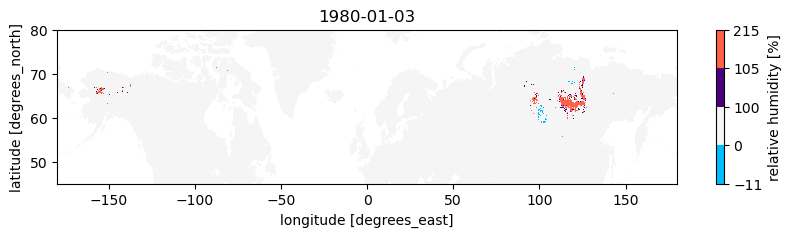

In [194]:
cmap=['deepskyblue','whitesmoke','indigo','tomato']

fig=plt.figure(figsize=(10,2))
ax=plt.subplot(111)

t='1980-01-03'
rhum.sel(time=t,lat=slice(80,45)).plot(ax=ax,levels=[-11,0,100,105,215],colors=cmap)
plt.title(t)
plt.show()

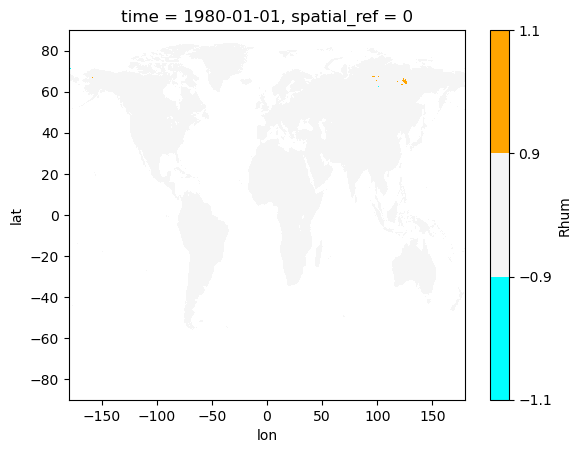

In [88]:
cmap=['cyan','whitesmoke','orange']
badvals.isel(time=0).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

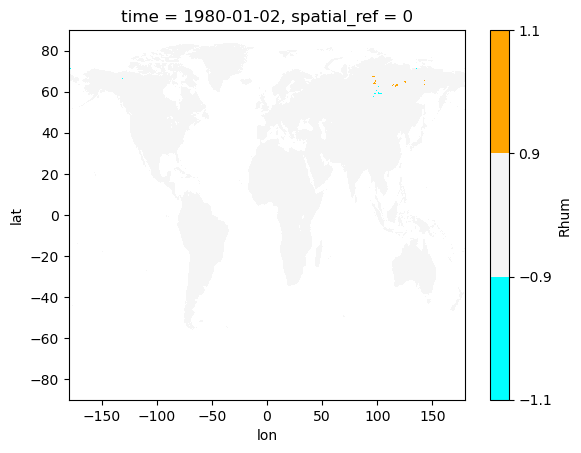

In [89]:
badvals.isel(time=1).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

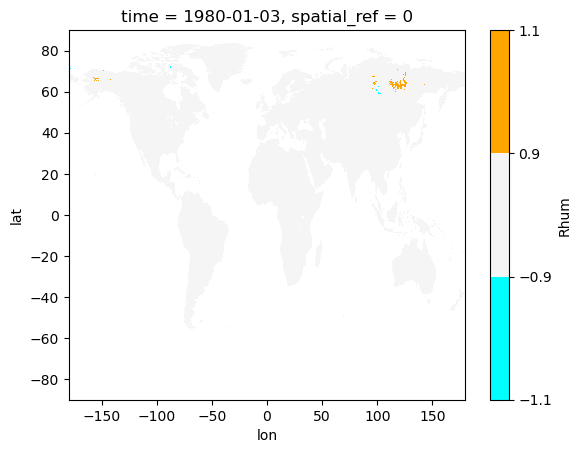

In [90]:
badvals.isel(time=2).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

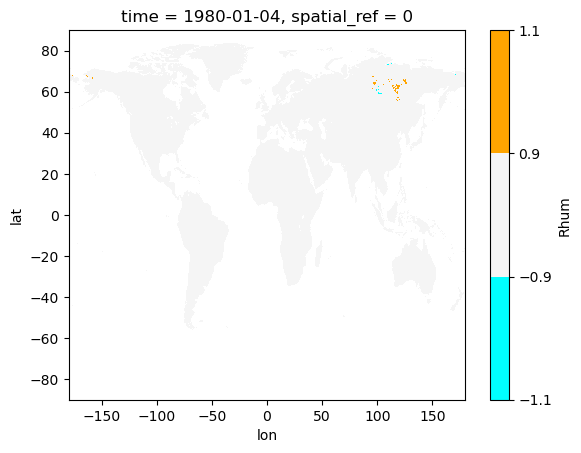

In [91]:
badvals.isel(time=3).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

In [117]:
vapr.sel(time='1980-01-05',lat=75.041664,lon=slice(-44.958332,-43.958332)).load()

<xarray.DataArray 'Vapr' (lon: 12)>
array([0.5246837 , 0.52212936, 0.5196624 , 0.5167585 , 0.5137155 ,
       0.5129539 , 0.51020044, 0.49731416, 0.49444884, 0.48161948,
       0.47944787, 0.478926  ], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-05
    lat          float32 75.04
  * lon          (lon) float32 -44.88 -44.79 -44.71 ... -44.12 -44.04 -43.96
    spatial_ref  int64 0
Attributes:
    standard_name:  Vapr
    long_name:      vapor pressure
    units:          hPa

In [118]:
tmax.sel(time='1980-01-05',lat=75.041664,lon=slice(-44.958332,-43.958332)).load()

<xarray.DataArray 'Tmax-2m' (lon: 12)>
array([-22.084116, -22.16242 , -22.225521, -22.277222, -22.34224 ,
       -22.373432, -22.41611 , -22.465   , -22.503523, -22.567879,
       -22.621   , -22.660585], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-05
    lat          float32 75.04
  * lon          (lon) float32 -44.88 -44.79 -44.71 ... -44.12 -44.04 -43.96
    spatial_ref  int64 0
Attributes:
    standard_name:  Tmax-2m
    long_name:      2m maximum surface air temperature
    units:          degrees C

In [119]:
tmin.sel(time='1980-01-05',lat=75.041664,lon=slice(-44.958332,-43.958332)).load()

<xarray.DataArray 'Tmin-2m' (lon: 12)>
array([-33.95255 , -34.07193 , -34.17662 , -34.262383, -34.354836,
       -34.397522, -34.47296 , -34.539185, -34.60899 , -34.702663,
       -34.78226 , -34.831623], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-05
    lat          float32 75.04
  * lon          (lon) float32 -44.88 -44.79 -44.71 ... -44.12 -44.04 -43.96
    spatial_ref  int64 0
Attributes:
    standard_name:  Tmin-2m
    long_name:      2m minimum surface air temperature
    units:          degrees C

In [121]:
rhum.sel(time='1980-01-05',lat=75.041664,lon=slice(-44.958332,-43.958332))

<xarray.DataArray 'Rhum' (lon: 12)>
array([46.451664, 46.6035  , 46.69848 , 46.695915, 46.728542, 46.805485,
       46.773335, 45.815445, 45.746876, 44.85482 , 44.89892 , 45.023556],
      dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-05
    lat          float32 75.04
  * lon          (lon) float32 -44.88 -44.79 -44.71 ... -44.12 -44.04 -43.96
    spatial_ref  int64 0
Attributes:
    standard_name:  Rhum
    long_name:      relative humidity
    units:          %

In [122]:
test_vs=0.5*( np.exp((17.27*-22)/(-22+237.3)) + np.exp((17.27*-34)/(-34+237.3)) )
print(test_vs)
test_rh=(0.5*0.1)/test_vs*100.
print(test_rh)

0.11345598512226411
44.06995360017214


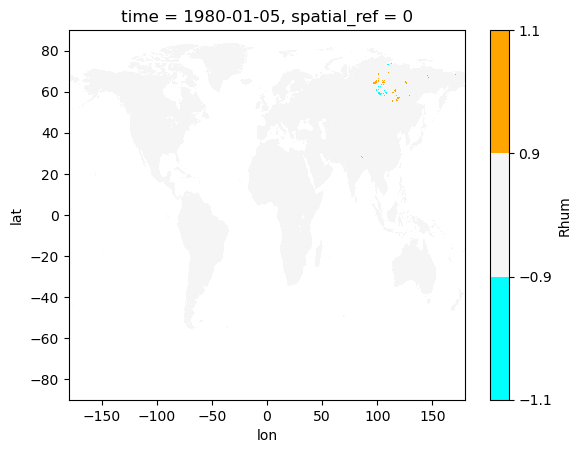

In [92]:
badvals.isel(time=4).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

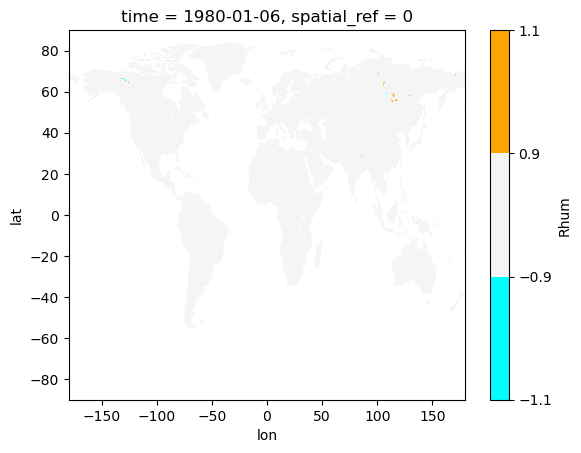

In [93]:
badvals.isel(time=5).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

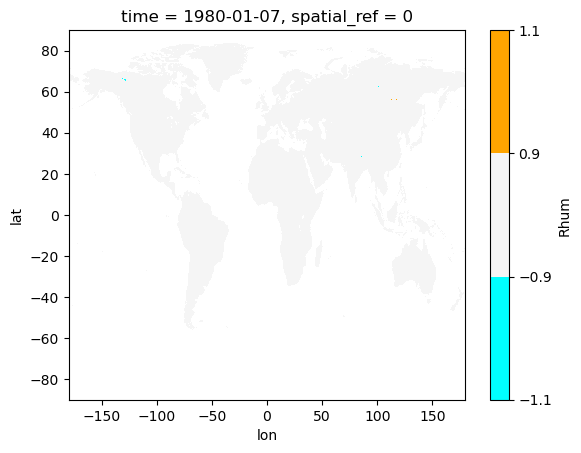

In [94]:
badvals.isel(time=6).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

In [145]:
badvals.sel(time='1980-01-08',lat=slice(55.71,55.5),lon=-129.95833)# 56.041668,53.041668 #-134.95833,-139.95833

<xarray.DataArray 'Rhum' (lat: 3)>
array([-1., -1., -1.], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-08
  * lat          (lat) float32 55.71 55.62 55.54
    lon          float32 -130.0
    spatial_ref  int64 0

In [146]:
rhum.sel(time='1980-01-08',lat=slice(55.71,55.5),lon=-129.95833)

<xarray.DataArray 'Rhum' (lat: 3)>
array([-0.12011646, -0.24119674, -0.17593908], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-08
  * lat          (lat) float32 55.71 55.62 55.54
    lon          float32 -130.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Rhum
    long_name:      relative humidity
    units:          %

In [148]:
vapr.sel(time='1980-01-08',lat=slice(55.71,55.5),lon=-129.95833).load()

<xarray.DataArray 'Vapr' (lat: 3)>
array([-0.00241268, -0.00426507, -0.00350714], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-08
  * lat          (lat) float32 55.71 55.62 55.54
    lon          float32 -130.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Vapr
    long_name:      vapor pressure
    units:          hPa

In [149]:
tmax.sel(time='1980-01-08',lat=slice(55.71,55.5),lon=-129.95833).load()

<xarray.DataArray 'Tmax-2m' (lat: 3)>
array([-16.972912, -18.179596, -16.71841 ], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-08
  * lat          (lat) float32 55.71 55.62 55.54
    lon          float32 -130.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Tmax-2m
    long_name:      2m maximum surface air temperature
    units:          degrees C

In [150]:
tmin.sel(time='1980-01-08',lat=slice(55.71,55.5),lon=-129.95833).load()

<xarray.DataArray 'Tmin-2m' (lat: 3)>
array([-24.465725, -26.408455, -25.19352 ], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-08
  * lat          (lat) float32 55.71 55.62 55.54
    lon          float32 -130.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Tmin-2m
    long_name:      2m minimum surface air temperature
    units:          degrees C

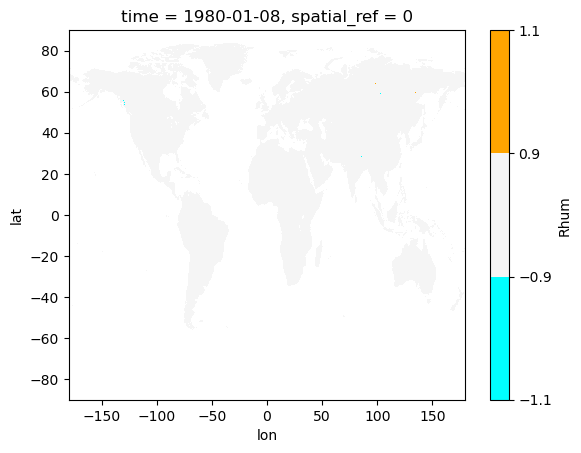

In [95]:
badvals.isel(time=7).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

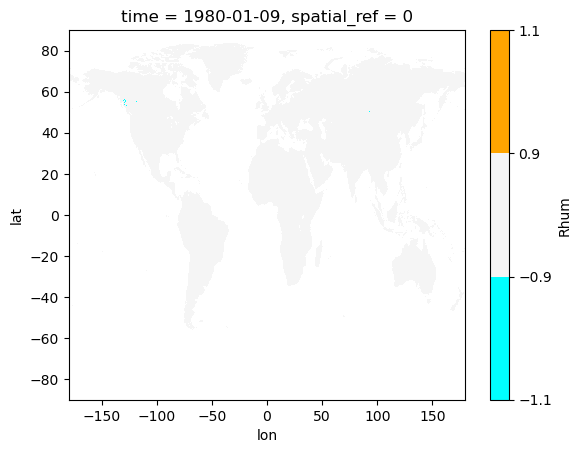

In [96]:
badvals.isel(time=8).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

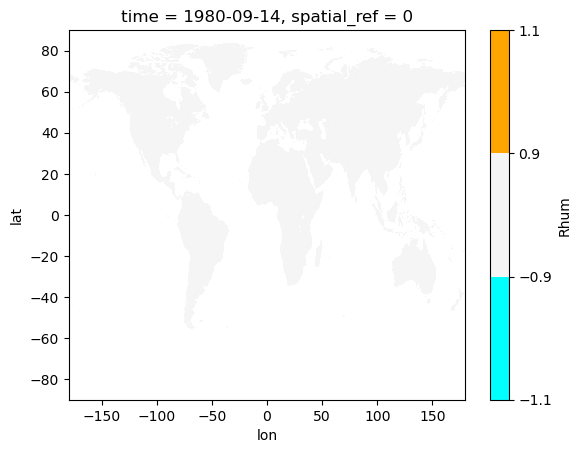

In [103]:
badvals.isel(time=257).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

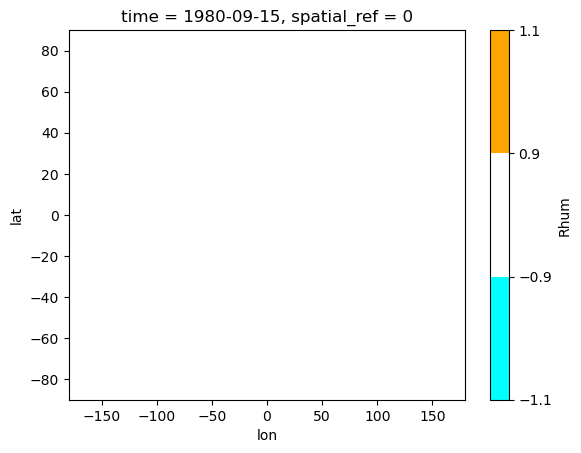

In [110]:
cmap=['cyan','white','orange']
badvals.isel(time=258).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

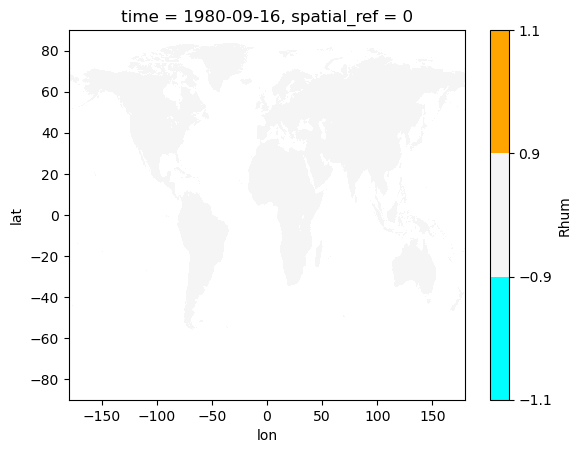

In [105]:
badvals.isel(time=259).plot(levels=[-1.1,-.9,.9,1.1],colors=cmap)

In [ ]:
test.min(),test.max()

In [11]:
neg=xr.where(rhum<0,1,0)
neg.shape

(366, 2160, 4320)

In [12]:
# which days have negative RH
nneg=neg.sum(axis=2).sum(axis=1)
nneg

<xarray.DataArray 'Rhum' (time: 366)>
array([ 262,  693,  913, 1155, 1758,  617,  324,  240,  415,  519,  200,
        128,  159,  391,  306,  365,  325,    4,    5,   25,   32,  131,
         37,  137,   19,   82,  208,  205,  132,  141,   88,   71,  123,
         41,   15,   17,   36,   40,   36,   24,   11,    4,    8,    5,
          1,    4,    1,    1,    1,    1,    1,    9,    2,    8,    4,
          0,   18,    3,    2,    1,    2,    5,    3,    2,    0,   22,
          0,    0,    1,    1,    1,    0,    0,    0,    7,    0,    3,
          0,    0,    0,    0,    0,    2,    0,    0,    0,    0,    0,
          1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   19,   17,    0,    0,    0,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    2,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    2,    0,
          0,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   20,    4,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    3,    3,    3,    0,
          0,    0,    0,    0,    0,    1,    0,    4,    0,    2,    0,
          3,    2,    5,   11,   20,   71,   41,   20,    9,  293,  836,
       1219,  896,  526,  596,  411,  398, 1335, 1326,  592,  457,  395,
        441,  644,  850,  652,  425,  267,  648,  392,  330,  251,  158,
         57,  547,  403,  195,  480,  956,  270,  469,  414,  294,   84,
         67,  138,  453,  172,   48,   39,   30,   35,  127,  172,  343,
        432,  138,  532])
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
    spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

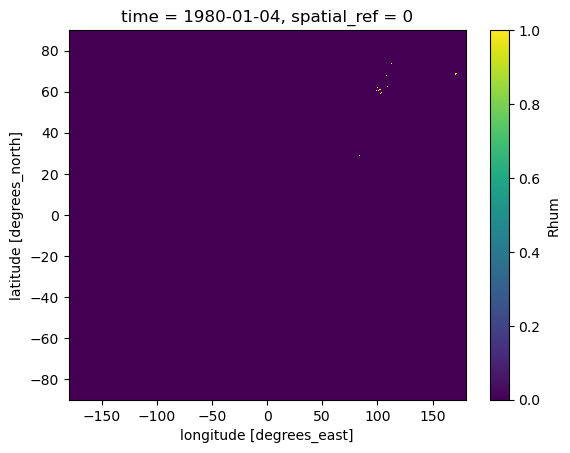

In [73]:
# plt.imshow(neg[3,:,:],interpolation=None)
# plt.colorbar()
neg[3,:,:].plot()

In [14]:
pos=xr.where(rhum>100,1,0)
npos=pos.sum(axis=2).sum(axis=1)
npos

<xarray.DataArray 'Rhum' (time: 366)>
array([1911, 1751, 7497, 4746, 2602, 1177,  157,  116,  124,   15,  768,
        640,  832, 2231,  659,  676,  676,   51,    2,    2,  125,  453,
        394,  475, 3131, 4188, 1554, 2821, 3619, 3209, 2428, 1601,  298,
         32,    1,   11,    3,    0,   12,   12,    7,   84,   29,    1,
          2,    0,    0,    0,    0,    0,    0,   86,   15,    1,    9,
          1,   67,   48,    5,   23,   75,  604, 2532, 1144,   45,    0,
          1,    2,    2,    0,    2,    3,    0,    0,    4,    8,   11,
          3,    0,    0,    0,    0,   71,  169,  124,    2,   29,   49,
        128,   12,   30,   15,   31,    3,    2,    1,    0,    2,    0,
          0,    0,    1,    3,   13,   10,   14,   15,    2,    0,    1,
          1,    1,    1,    1,    0,    3,    3,    1,    1,    1,    1,
          1,    1,    0,    1,    1,    5,    0,    3,    0,    3,    2,
          1,    0,    3,    0,    2,    2,    4,    2,    3,    3,    3,
          1,    0,    0,    0,    1,    1,    2,    5,    1,    2,    2,
          2,    2,    2,    2,    2,    4,    3,    5,    5,    5,    4,
          5,    3,    3,    3,    2,    2,    3,    5,    6,    2,    2,
          3,    6,    7,    4,    2,    3,    2,    2,    4,    3,    4,
          5,    7,    6,    5,    4,    7,    9,    6,    5,    7,    6,
          8,    6,    6,    5,    7,    5,    3,    6,    2,    7,    4,
          6,    6,    6,    6,    8,    6,    3,    2,    2,    2,    4,
          6,    5,    4,    3,    4,    2,    2,    0,    3,    2,    7,
          3,    3,    1,    4,    3,    0,    2,    1,    1,    2,    3,
          2,    4,    4,    3,    2,    2,    3,    1,    2,    3,    3,
          1,    1,    2,    6,    8,    4,    1,    1,    1,    3,    3,
          3,    3,    3,    3,    2,    1,    2,    1,    3,    3,    2,
          0,    1,    0,    3,    1,    1,    2,    3,    1,    2,    2,
          2,    2,    2,    2,    3,    3,    1,    1,    1,    2,    0,
          0,    1,    0,    1,    1,    0,    7,    8,    7,    4,    1,
          4,    4,    4,    3,    4,   24,   12,    0,    1,    0,   15,
         14,   39,  118,  427,  417,  247,  324,  398,  431,  402,  758,
        942, 1037,  852,  608,  299,  242,  201,   56,  138,  404,  906,
        304,   57,  177,   95,   51,  239,  163,  122,   86,  260,  251,
         36,   72,   82,   55,   74,   14,    8,    4,  450, 1427,  526,
          5,    1,    9])
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
    spatial_ref  (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

In [59]:
neg.lat.sel(lat=60,method='nearest')

<xarray.DataArray 'lat' ()>
array(60.041668, dtype=float32)
Coordinates:
    lat      float32 60.04
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [72]:
neg.sel(time='1980-01-04',lat=slice(64.208336,64.041664),lon=103.041664).load()

<xarray.DataArray 'Rhum' (lat: 3)>
array([1, 1, 1])
Coordinates:
    time         datetime64[ns] 1980-01-04
  * lat          (lat) float32 64.21 64.12 64.04
    lon          float32 103.0
    spatial_ref  int64 0

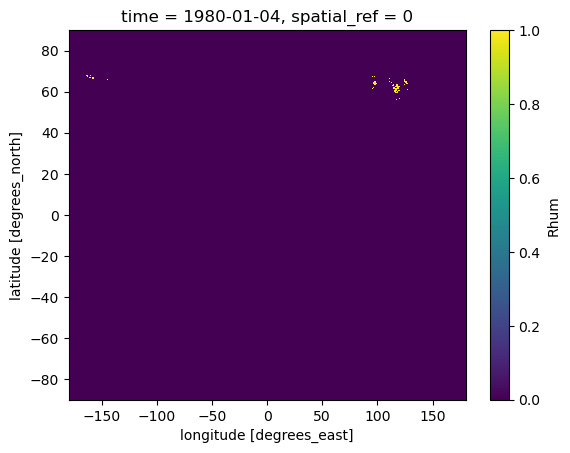

In [15]:
pos[3,:,:].plot()

In [29]:
pos.sel(time='1980-01-04',lat=60,lon=125,method='nearest')

<xarray.DataArray 'Rhum' ()>
array(0)
Coordinates:
    time         datetime64[ns] 1980-01-04
    lat          float32 60.04
    lon          float32 125.0
    spatial_ref  int64 0

In [46]:
test=pos.sel(time='1980-01-04',lat=slice(65.291664,64.625),lon=125.041664)
test

<xarray.DataArray 'Rhum' (lat: 8)>
array([1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
    time         datetime64[ns] 1980-01-04
  * lat          (lat) float32 65.21 65.12 65.04 64.96 64.88 64.79 64.71 64.62
    lon          float32 125.0
    spatial_ref  int64 0

In [43]:
# np.nonzero(test)
# test[0]
np.argwhere(test.data)
rhum.lat[296:305]

<xarray.DataArray 'lat' (lat: 9)>
array([65.291664, 65.208336, 65.125   , 65.041664, 64.958336, 64.875   ,
       64.791664, 64.708336, 64.625   ], dtype=float32)
Coordinates:
  * lat      (lat) float32 65.29 65.21 65.12 65.04 64.96 64.88 64.79 64.71 64.62
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [ ]:
for t in test.time:
    neg=np.where(test.sel(time=t)<0,1,0)
    print(t.data,sum(neg.data))
# neg=test.isel(time=0).where(test.isel(time=0)<0).plot()

In [ ]:
test.isel(time=0).where(test>100).plot()

In [6]:
# lazy get vapr
vapr=xr.open_dataset(day_dir+'Vapr_daily_1980_5m.nc',chunks=-1)['Vapr']

# lazy get tmax
tmax=xr.open_dataset(day_dir+'Tmax-2m_daily_1980_5m.nc',chunks=-1)['Tmax-2m']

# lazy get tmin
tmin=xr.open_dataset(day_dir+'Tmin-2m_daily_1980_5m.nc',chunks=-1)['Tmin-2m']

In [7]:
vapr

<xarray.DataArray 'Vapr' (time: 366, lat: 2160, lon: 4320)>
dask.array<open_dataset-b0692ce1d1834b53d242e34b8cc327beVapr, shape=(366, 2160, 4320), dtype=float32, chunksize=(366, 2160, 4320), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1980-12-31
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  (time) int64 dask.array<chunksize=(366,), meta=np.ndarray>
Attributes:
    standard_name:  Vapr
    long_name:      vapor pressure
    units:          hPa

In [49]:
vapr.sel(time='1980-01-04',lat=slice(65.291664,64.625),lon=125.041664).load()

<xarray.DataArray 'Vapr' (lat: 8)>
array([0.12287644, 0.16655242, 0.20240185, 0.22297709, 0.2438325 ,
       0.20165738, 0.17202982, 0.1668643 ], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-04
  * lat          (lat) float32 65.21 65.12 65.04 64.96 64.88 64.79 64.71 64.62
    lon          float32 125.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Vapr
    long_name:      vapor pressure
    units:          hPa

In [50]:
tmax.sel(time='1980-01-04',lat=slice(65.291664,64.625),lon=125.041664).load()

<xarray.DataArray 'Tmax-2m' (lat: 8)>
array([-47.527325, -46.49491 , -45.418564, -44.697758, -43.89467 ,
       -44.261494, -45.40477 , -45.570282], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-04
  * lat          (lat) float32 65.21 65.12 65.04 64.96 64.88 64.79 64.71 64.62
    lon          float32 125.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Tmax-2m
    long_name:      2m maximum surface air temperature
    units:          degrees C

In [51]:
tmin.sel(time='1980-01-04',lat=slice(65.291664,64.625),lon=125.041664).load()

<xarray.DataArray 'Tmin-2m' (lat: 8)>
array([-52.384346, -51.377174, -49.9031  , -48.797684, -47.490543,
       -48.040276, -49.598423, -49.785503], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-04
  * lat          (lat) float32 65.21 65.12 65.04 64.96 64.88 64.79 64.71 64.62
    lon          float32 125.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Tmin-2m
    long_name:      2m minimum surface air temperature
    units:          degrees C

In [123]:
test_vs=0.5*( np.exp((17.27*-47.527)/(-47.527+237.3)) + np.exp((17.27*-52.384)/(-52.384+237.3)) )
print(test_vs)
test_rh=(0.12287644*.1)/test_vs*100.
print(test_rh)

0.010367897701080634
118.51625425200014


In [74]:
vapr.sel(time='1980-01-04',lat=slice(64.208336,64.041664),lon=103.041664).load()

<xarray.DataArray 'Vapr' (lat: 3)>
array([-1.1916608e-03, -1.9874945e-03, -3.8340688e-05], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-04
  * lat          (lat) float32 64.21 64.12 64.04
    lon          float32 103.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Vapr
    long_name:      vapor pressure
    units:          hPa

In [75]:
tmax.sel(time='1980-01-04',lat=slice(64.208336,64.041664),lon=103.041664).load()

<xarray.DataArray 'Tmax-2m' (lat: 3)>
array([-45.37131 , -46.22207 , -45.619625], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-04
  * lat          (lat) float32 64.21 64.12 64.04
    lon          float32 103.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Tmax-2m
    long_name:      2m maximum surface air temperature
    units:          degrees C

In [76]:
tmin.sel(time='1980-01-04',lat=slice(64.208336,64.041664),lon=103.041664).load()

<xarray.DataArray 'Tmin-2m' (lat: 3)>
array([-52.82246 , -54.13259 , -53.685337], dtype=float32)
Coordinates:
    time         datetime64[ns] 1980-01-04
  * lat          (lat) float32 64.21 64.12 64.04
    lon          float32 103.0
    spatial_ref  int64 0
Attributes:
    standard_name:  Tmin-2m
    long_name:      2m minimum surface air temperature
    units:          degrees C

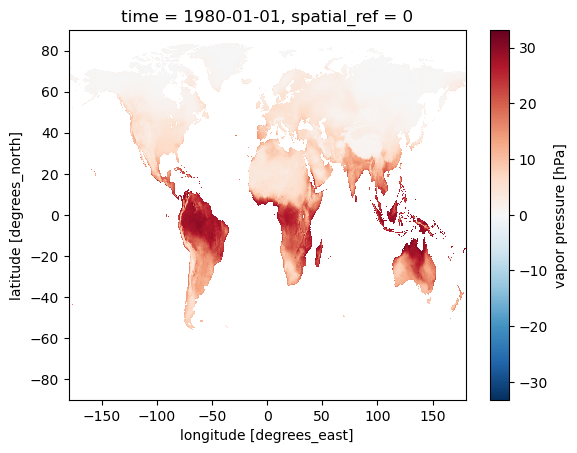

In [9]:
vapr.isel(time=0).plot()

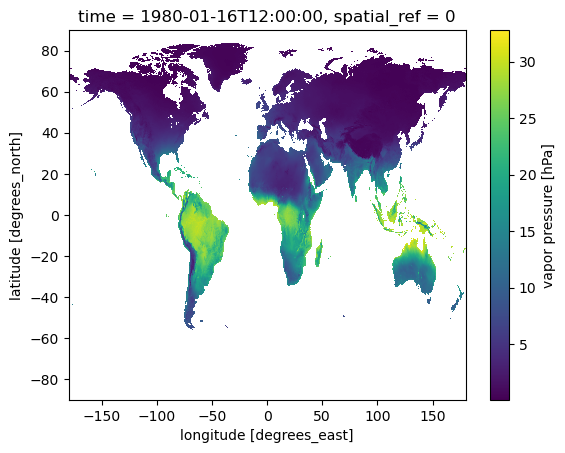

In [12]:
var_mean=xr.open_dataset(mfiles[4],chunks=-1)['Vapr']
var_mean.isel(time=0).plot()

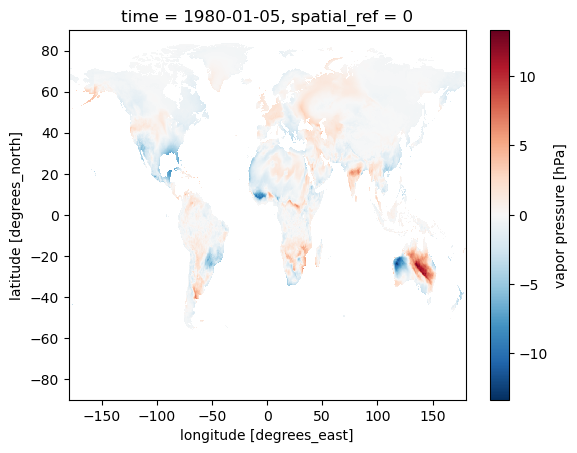

In [16]:
var_prime=xr.open_dataset(ddfiles[4], chunks=-1)['Vapr']
var_prime.isel(time=4).plot()

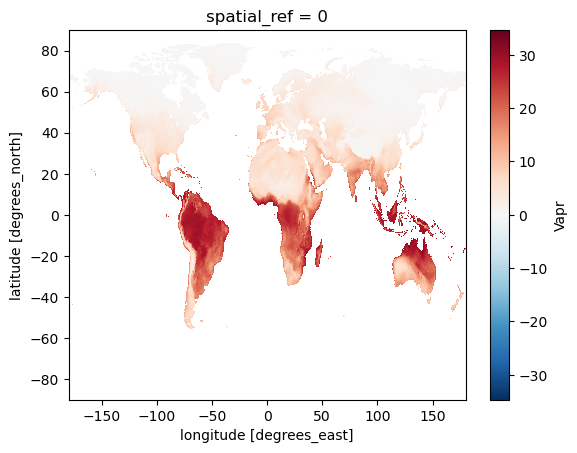

In [17]:
vbar=var_mean[0,:,:]
vtick=var_prime[4,:,:]
vday=vbar+vtick
vday.plot()

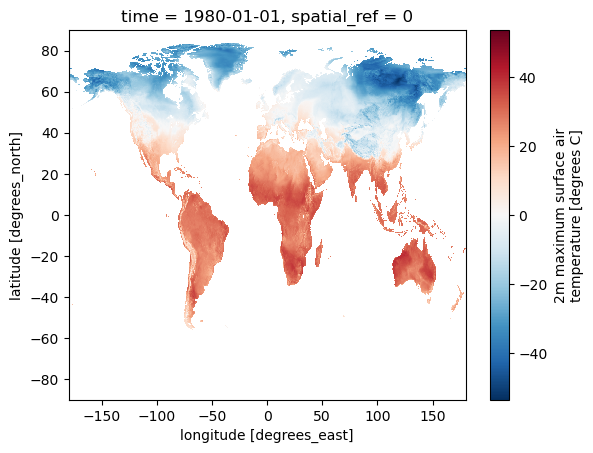

In [10]:
tmax.isel(time=0).plot()

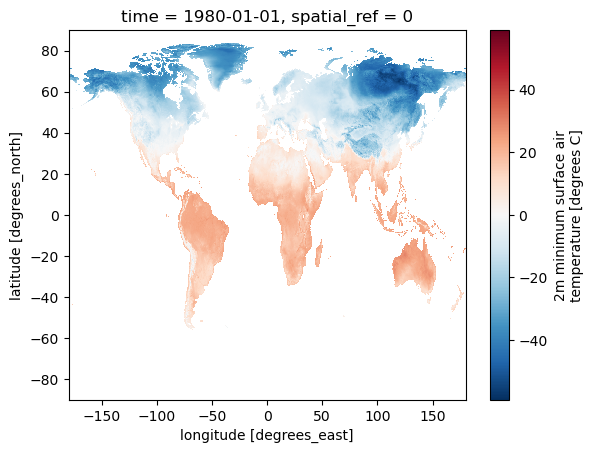

In [11]:
tmin.isel(time=0).plot()